In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

In [ ]:
cd /content/gdrive/MyDrive/Masterarbeit/medmnist

/content/gdrive/MyDrive/Masterarbeit/medmnist


In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import medmnist
from medmnist import INFO, Evaluator
info = INFO['pneumoniamnist']
DataClass = getattr(medmnist, info['python_class'])
print(info["task"])

binary-class


In [ ]:
import torchvision.transforms as transforms
data_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
train_dataset = DataClass(split='train',transform = data_transform, download=True)
val_dataset = DataClass(split='val', transform = data_transform, download=True)
test_dataset = DataClass(split='test', transform = data_transform, download=True)

pil_dataset = DataClass(split='train', download=True)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


# Data Inspection

/usr/local/lib/python3.9/dist-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


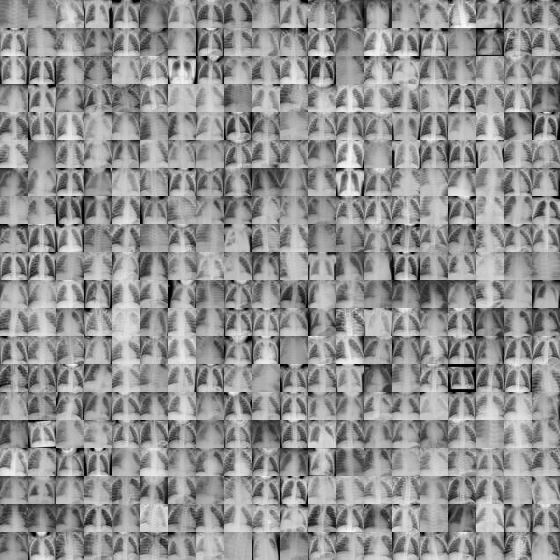

In [ ]:
train_dataset.montage(length=20)

In [ ]:
# Split samples in positive and negative ones, to plot them seperately and visually see the different characteristics of the classes
import numpy as np
import matplotlib.pyplot as pyplot

positive = []
negative = []
for i in range(100):
  el = train_dataset[i]
  if el[1] == 1:
    positive.append(el)
  else: 
    negative.append(el)


Plot postive samples (pneumonia): 


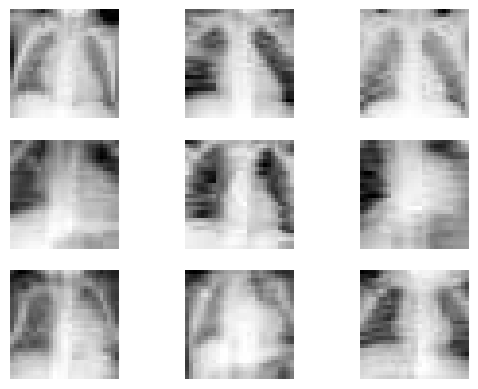

In [ ]:
print("Plot postive samples (pneumonia): ")
for i in range(9):
  # define subplot
  pyplot.subplot(3, 3, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  im = positive[i][0]
  imm = np.squeeze(im)
  pyplot.imshow(imm, cmap='gray')
pyplot.show()

Plot negative samples (healthy): 


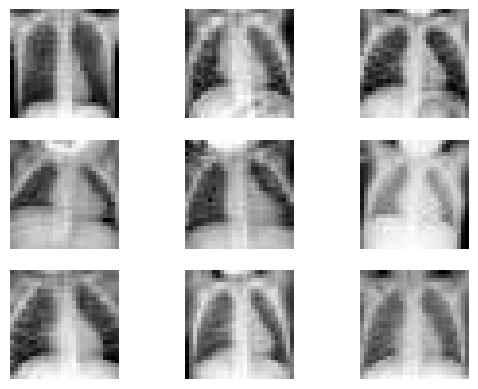

In [ ]:
print("Plot negative samples (healthy): ")
for i in range(9):
  # define subplot
  pyplot.subplot(3, 3, 1 + i)
  # turn off axis
  pyplot.axis('off')
  # plot raw pixel data
  im = negative[i][0]
  imm = np.squeeze(im)
  pyplot.imshow(imm, cmap='gray')
pyplot.show()

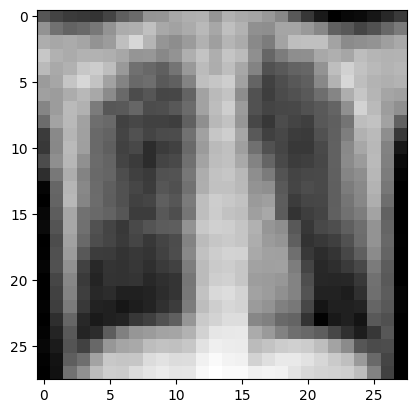

In [ ]:
# Inspect one sample on a larger scale. 
a = train_dataset[5][0].numpy()
pyplot.imshow(np.squeeze(a), interpolation='nearest', cmap="gray")

# Data Preprocessing & Dataset Generation

In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")
data_flag = "pneumoniamnist"
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

MedMNIST v2.2.1 @ https://github.com/MedMNIST/MedMNIST/


In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor()])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform = data_transform, download=True)

test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


In [ ]:
#  Reshape the dataset into a format that is required by the proposed models. Using numpy arrays instead of tensors. 
def reshape(data):
  X = []
  y = []
  for el,ar in data:
    el_arr = el.numpy()
    X.append(el_arr)
    y.append(ar)
  X_arr = X[0]
  for i in range(len(X)):
    if i > 0: 
      newrow = X[i]
      X_arr = np.vstack([X_arr, newrow])
  y_arr = y[0]
  for i in range(len(y)):
    if i > 0:
      newrow = y[i]
      y_arr = np.vstack([y_arr, newrow])
  y_arr_sq = np.squeeze(y_arr)

  return X_arr, y_arr_sq

realX, realy = reshape(train_dataset)
valX, valy = reshape(val_dataset)
testX, testy = reshape(test_dataset)

train = list(zip(realX, realy))
val = list(zip(valX, valy))
test = list(zip(testX, testy))


In [ ]:

import random
from random import randint

# Create sample pairs with a binary label indicating if they are from the same class or not

def make_pairs(data):
  positives = [t for t in train if t[1] == 1]
  negatives = [t for t in train if t[1] == 0]
  
  same_pairs = []
  factor = 3
  for i in positives:
    for r in range(0,factor):
      random_ind = randint(0, len(positives) - 1)
      ex = positives[random_ind][0]
      same_pairs.append((i[0], ex, 1))
  for i in negatives:
    for r in range(0,factor):
      random_ind = randint(0, len(negatives) - 1)
      ex = negatives[random_ind][0]
      same_pairs.append((i[0], ex, 1))
    
  diff_pairs = []
  factor = 3
  for i in positives:
    for r in range(0,factor):
      random_ind = randint(0, len(negatives) - 1)
      ex = negatives[random_ind][0]
      diff_pairs.append((i[0], ex, 0))
  for i in negatives:
    for r in range(0,factor):
      random_ind = randint(0, len(positives) - 1)
      ex = positives[random_ind][0]
      diff_pairs.append((i[0], ex, 0))
  
  dataset = same_pairs + diff_pairs
  sample = random.sample(dataset, k=len(dataset))
  
  return sample


In [ ]:
# Split dataset into training, validation and test split
def split_data(data):
  X_1 = np.asarray([i[0] for i in data])
  X_2 = np.asarray([i[1] for i in data])
  y = np.asarray([i[2] for i in data])
  return X_1, X_2, y


data = make_pairs(train)
train_data = data[:22000]
val_data = data[22001:25000]
test_data = data[25001:]


X_1_np, X_2_np, y_np = split_data(train_data)
X_1_np_val, X_2_np_val, y_np_val = split_data(val_data)
X_1_np_test, X_2_np_test, y_np_test = split_data(test_data)

# Siamese Neural Network

In [ ]:
from keras.layers import Input, Dense, InputLayer, Conv2D, MaxPooling2D, UpSampling2D, InputLayer, Concatenate, Flatten, Reshape, Lambda, Embedding, dot, Dropout
from keras.models import Model, load_model, Sequential
import matplotlib.pyplot as plt
import keras.backend as K
from sklearn.model_selection import train_test_split
import os, sys
import tensorflow as tf
from keras.utils.vis_utils import plot_model


def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def loss(margin=1):

    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        # square_pred = y_pred


        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        # margin_square = tf.math.maximum(margin - (y_pred), 0)

        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss




# Train autoencoder and save encoder model and encodings
def train_siamese(X1, X2, y, loss) :


    # Sub-network Architecture
    input_layer = Input((28, 28,1))
    layer1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    layer2 = Dropout(0.1)(layer1)
    layer3 = MaxPooling2D((2, 2), padding='same')(layer2)
    layer4 = Conv2D(16, (3, 3), activation='relu', padding='same')(layer3)
    layer5 = Dropout(0.1)(layer4)
    layer6 = MaxPooling2D((2, 2), padding='same')(layer5)
    layer7= Flatten()(layer6)
    embeddings = Dense(16, activation=None)(layer7)
    norm_embeddings = tf.nn.l2_normalize(embeddings, axis=-1)


    # Create model
    model = Model(inputs=input_layer, outputs=norm_embeddings)


    # Create siamese model
    input1 = Input((28,28,1))
    input2 = Input((28,28,1))

    # Create left and right twin models
    left_model = model(input1)
    right_model = model(input2)


    # Dot product layer
    dot_product = dot([left_model, right_model], axes=1, normalize=False)

    siamese_model = Model(inputs=[input1, input2], outputs=dot_product)

    # Model summary 
    print(siamese_model.summary())

    # Compile model    
    siamese_model.compile(optimizer='adam', loss="mse")
 
    # Plot flowchart fo model
    plot_model(siamese_model, to_file=os.getcwd()+'/siamese_model_mnist.png', show_shapes=1, show_layer_names=1)


    # Fit model
    siamese_model.fit([X1, X2], y, epochs=10, batch_size=2, shuffle=True, verbose=True)

    model.save(os.getcwd()+"/cl_encoder_drop.h5")
    siamese_model.save(os.getcwd()+"/cl_siamese_model_drop.h5")

    return model, siamese_model

In [ ]:
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, shutil
from random import random, randint, seed
import random
import pickle, itertools, sklearn, pandas as pd, seaborn as sn
from scipy.spatial import distance
from keras.models import Model, load_model, Sequential
from keras import backend as K
from keras.utils.vis_utils import plot_model
from scipy import spatial
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')


model, siamese_model = train_siamese(X_1_np, X_2_np, y_np, loss(margin=1.5))

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model_4 (Functional)           (None, 16)           17504       ['input_8[0][0]',                
                                                                  'input_9[0][0]']                
                                                                                                  
 dot_2 (Dot)                    (None, 1)            0           ['model_4[0][0]',          

# Embedding space visualization

In [ ]:
pip install chart-studio

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import os, sys, cv2, matplotlib.pyplot as plt, numpy as np, pickle
import sklearn, pandas as pd, seaborn as sn
from keras.models import Model, load_model, Sequential
from keras import backend as K
from sklearn.metrics import confusion_matrix

from chart_studio import plotly as py
import plotly.graph_objects as go
import plotly.io as pio

import warnings
warnings.filterwarnings('ignore')


# Load models
# Specify the path to the models
model = load_model(os.getcwd()+"/mse_encoder.h5")
siamese_model = load_model(os.getcwd()+"/mse_siamese_model.h5")

# Predict
pred = model.predict(realX)


colors = ['green','red'] # set colors of target labels

# Set target labels
y = [colors[i] for i in realy]


feat1 = pred[:,0]
feat2 = pred[:,1]
feat3 = pred[:,2]


scatter = dict(
    mode = "markers",
    name = "y",
    type = "scatter3d",
    x = feat1, y = feat2, z = feat3,
    marker=dict(size=2, color=y)
)

layout = dict(
    title = '3d point clustering',
    scene = dict(
        xaxis = dict( zeroline=False ),
        yaxis = dict( zeroline=False ),
        zaxis = dict( zeroline=False ),
    )
)
fig = dict( data=[scatter], layout=layout )
print("3 dimensional visualization along the three most important dimensions found by the pca")
pio.show(fig)

148/148 [==============================] - 2s 2ms/step


<Figure size 640x480 with 0 Axes>

### SNN Evaluation

In [ ]:
from sklearn.metrics import accuracy_score

predictions = siamese_model.predict([X_1_np, X_2_np])
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1
print("Train Acc: ", accuracy_score(y_np,predictions))

688/688 [==============================] - 1s 2ms/step


0.9948636363636364

In [ ]:
predictions = siamese_model.predict([X_1_np_val, X_2_np_val])
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1
print("Val Acc: ", accuracy_score(y_np_val,predictions))

94/94 [==============================] - 0s 3ms/step


0.9933311103701233

In [ ]:
predictions = siamese_model.predict([X_1_np_test, X_2_np_test])
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1
print("Test Acc: ", accuracy_score(y_np_test,predictions))

102/102 [==============================] - 0s 3ms/step


# SNN Results Examples

In [ ]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):

    num_row = to_show // num_col if to_show // num_col != 0 else 1

    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

32/32 [==============================] - 0s 2ms/step


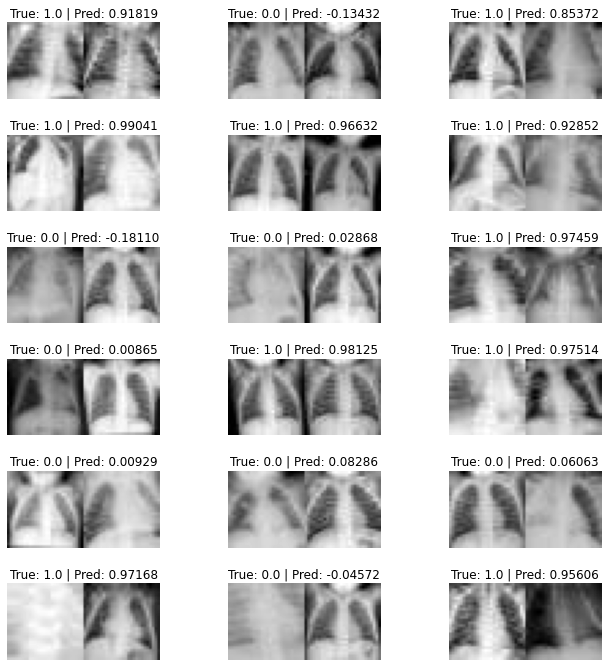

In [ ]:
predictions = siamese_model.predict([X_1_np_test, X_2_np_test])
visualize([X_1_np_test, X_2_np_test], labels_test, to_show=20, predictions=predictions, test=True)

# Pneumonia Detection Evaluation

In [ ]:
# Computation of the healthy reference - Cluster centroid

realX, realy = reshape(train_dataset)
embeddings = model.predict(realX)
train = list(zip(embeddings, realy))
positives = [t for t in train if t[1] == 1]
positive_images = np.array([i[0] for i in positives])
positive_centroid = np.mean(positive_images, axis=0)
negatives = [t for t in train if t[1] == 0]
negative_images = np.array([i[0] for i in negatives])
negative_centroid = np.mean(negative_images, axis=0)

In [ ]:
def distance_prediction(centroid_healthy, centroid_sick, points): 
  distances = []
  for point in points: 
    dist_to_healthy = np.linalg.norm(point-centroid_healthy)
    dist_to_sick = np.linalg.norm(point-centroid_sick)
    res = (dist_to_healthy /  (dist_to_healthy + dist_to_sick))
    distances.append(res)
  return np.array(distances)

In [ ]:
def distance_prediction_cosine(centroid_healthy, centroid_sick, points): 
  distances = []
  for point in points: 
    p = point / np.linalg.norm(point)
    c = centroid_healthy / np.linalg.norm(centroid_healthy)
    d = np.dot(p,c)
    d = d + 1
    d = d / 2
    d = 1 - d
    distances.append(d)
  return np.array(distances)

In [ ]:
def distance_to_centroid(centroid, points):
  distances = []
  for point in points:
    dist = np.linalg.norm(point-centroid)
    distances.append(dist)
  return np.array(distances)


In [ ]:
# Euclidean Prediction
pred = distance_prediction(negative_centroid, positive_centroid, embeddings)
for i in range(20):
  threshold = 0.05 * i
  predictions = np.copy(pred)
  predictions[predictions > threshold] = 1
  predictions[predictions < threshold] = 0
  predictions = predictions.astype(int)
  acc = accuracy_score(realy, predictions)
  print("Threshold: ", threshold, " Accuracy: ", acc)




Threshold:  0.0  Accuracy:  0.7421410365335599
Threshold:  0.05  Accuracy:  0.7421410365335599
Threshold:  0.1  Accuracy:  0.7421410365335599
Threshold:  0.15000000000000002  Accuracy:  0.7421410365335599
Threshold:  0.2  Accuracy:  0.7313084112149533
Threshold:  0.25  Accuracy:  0.3181818181818182
Threshold:  0.30000000000000004  Accuracy:  0.04099405267629567
Threshold:  0.35000000000000003  Accuracy:  0.009770603228547154
Threshold:  0.4  Accuracy:  0.002973661852166525
Threshold:  0.45  Accuracy:  0.0019116397621070519
Threshold:  0.5  Accuracy:  0.2578589634664401
Threshold:  0.55  Accuracy:  0.2578589634664401
Threshold:  0.6000000000000001  Accuracy:  0.2578589634664401
Threshold:  0.65  Accuracy:  0.2578589634664401
Threshold:  0.7000000000000001  Accuracy:  0.2578589634664401
Threshold:  0.75  Accuracy:  0.2578589634664401
Threshold:  0.8  Accuracy:  0.2578589634664401
Threshold:  0.8500000000000001  Accuracy:  0.2578589634664401
Threshold:  0.9  Accuracy:  0.2578589634664401


In [ ]:
# Cosine Prediction
pred = distance_prediction_cosine(negative_centroid, positive_centroid, embeddings)
for i in range(20):
  threshold = 0.05 * i
  predictions = np.copy(pred)
  predictions[predictions > threshold] = 1
  predictions[predictions < threshold] = 0
  predictions = predictions.astype(int)
  acc = accuracy_score(realy, predictions)
  print("Threshold: ", threshold, " Accuracy: ", acc)


Threshold:  0.0  Accuracy:  0.7421410365335599
Threshold:  0.05  Accuracy:  0.9910790144435004
Threshold:  0.1  Accuracy:  0.9980883602378929
Threshold:  0.15000000000000002  Accuracy:  0.9978759558198811
Threshold:  0.2  Accuracy:  0.9970263381478335
Threshold:  0.25  Accuracy:  0.9949022939677146
Threshold:  0.30000000000000004  Accuracy:  0.9902293967714528
Threshold:  0.35000000000000003  Accuracy:  0.9806711979609176
Threshold:  0.4  Accuracy:  0.9590059473237044
Threshold:  0.45  Accuracy:  0.8946474086661003
Threshold:  0.5  Accuracy:  0.6818181818181818
Threshold:  0.55  Accuracy:  0.3409090909090909
Threshold:  0.6000000000000001  Accuracy:  0.26869158878504673
Threshold:  0.65  Accuracy:  0.25892098555649956
Threshold:  0.7000000000000001  Accuracy:  0.2578589634664401
Threshold:  0.75  Accuracy:  0.2578589634664401
Threshold:  0.8  Accuracy:  0.2578589634664401
Threshold:  0.8500000000000001  Accuracy:  0.2578589634664401
Threshold:  0.9  Accuracy:  0.2578589634664401
Thresh

## Evaluation Validation Set

In [ ]:
valX, valy = reshape(val_dataset)

In [ ]:
embeddings_val = model.predict(valX)

17/17 [==============================] - 0s 5ms/step


In [ ]:
pred_test = distance_prediction(negative_centroid, positive_centroid, embeddings_val)

In [ ]:
# Euclidean Prediction
pred_test = distance_prediction(negative_centroid, positive_centroid, embeddings_val)
for i in range(40):
  threshold = 0.05 * i
  predictions = np.copy(pred_test)
  predictions[predictions > threshold] = 1
  predictions[predictions < threshold] = 0
  predictions = predictions.astype(int)
  acc = accuracy_score(valy, predictions)
  print("Threshold: ", threshold, " Accuracy: ", acc)

Threshold:  0.0  Accuracy:  0.7423664122137404
Threshold:  0.05  Accuracy:  0.7423664122137404
Threshold:  0.1  Accuracy:  0.8053435114503816
Threshold:  0.15000000000000002  Accuracy:  0.8740458015267175
Threshold:  0.2  Accuracy:  0.9255725190839694
Threshold:  0.25  Accuracy:  0.9484732824427481
Threshold:  0.30000000000000004  Accuracy:  0.9656488549618321
Threshold:  0.35000000000000003  Accuracy:  0.9713740458015268
Threshold:  0.4  Accuracy:  0.9732824427480916
Threshold:  0.45  Accuracy:  0.9751908396946565
Threshold:  0.5  Accuracy:  0.9732824427480916
Threshold:  0.55  Accuracy:  0.9713740458015268
Threshold:  0.6000000000000001  Accuracy:  0.9713740458015268
Threshold:  0.65  Accuracy:  0.9618320610687023
Threshold:  0.7000000000000001  Accuracy:  0.9580152671755725
Threshold:  0.75  Accuracy:  0.9446564885496184
Threshold:  0.8  Accuracy:  0.916030534351145
Threshold:  0.8500000000000001  Accuracy:  0.8396946564885496
Threshold:  0.9  Accuracy:  0.7022900763358778
Threshold

In [ ]:
# Cosine Prediction
pred_test_cosine = distance_prediction_cosine(negative_centroid, positive_centroid, embeddings_val)
for i in range(20):
  threshold = 0.05 * i
  predictions = np.copy(pred_test_cosine)
  predictions[predictions > threshold] = 1
  predictions[predictions < threshold] = 0
  predictions = predictions.astype(int)
  acc = accuracy_score(valy, predictions)
  print("Threshold: ", threshold, " Accuracy: ", acc)

Threshold:  0.0  Accuracy:  0.7423664122137404
Threshold:  0.05  Accuracy:  0.9541984732824428
Threshold:  0.1  Accuracy:  0.9732824427480916
Threshold:  0.15000000000000002  Accuracy:  0.9732824427480916
Threshold:  0.2  Accuracy:  0.9713740458015268
Threshold:  0.25  Accuracy:  0.9675572519083969
Threshold:  0.30000000000000004  Accuracy:  0.9580152671755725
Threshold:  0.35000000000000003  Accuracy:  0.9370229007633588
Threshold:  0.4  Accuracy:  0.9103053435114504
Threshold:  0.45  Accuracy:  0.8530534351145038
Threshold:  0.5  Accuracy:  0.666030534351145
Threshold:  0.55  Accuracy:  0.3473282442748092
Threshold:  0.6000000000000001  Accuracy:  0.28435114503816794
Threshold:  0.65  Accuracy:  0.2595419847328244
Threshold:  0.7000000000000001  Accuracy:  0.25763358778625955
Threshold:  0.75  Accuracy:  0.25763358778625955
Threshold:  0.8  Accuracy:  0.25763358778625955
Threshold:  0.8500000000000001  Accuracy:  0.25763358778625955
Threshold:  0.9  Accuracy:  0.25763358778625955
Thr

## Evaluation Test Set

In [ ]:
testX, testy = reshape(test_dataset)

In [ ]:
embeddings_test = model.predict(testX)

20/20 [==============================] - 0s 1ms/step


In [ ]:
# Euclidean Prediction
pred_test = distance_prediction(negative_centroid, positive_centroid, embeddings_test)
threshold = 0.5
predictions = np.copy(pred_test)
predictions[predictions > threshold] = 1
predictions[predictions < threshold] = 0
predictions = predictions.astype(int)
acc = accuracy_score(testy, predictions)
print("Threshold: ", threshold, " Accuracy: ", acc)

In [ ]:
# Cosine Prediction
pred_test_cosine = distance_prediction_cosine(negative_centroid, positive_centroid, embeddings_test)
threshold = 0.2
predictions = np.copy(pred_test_cosine)
predictions[predictions > threshold] = 1
predictions[predictions < threshold] = 0
predictions = predictions.astype(int)
acc = accuracy_score(testy, predictions)
print("Threshold: ", threshold, " Accuracy: ", acc)

# CNN Classifier Benchmark

In [ ]:
from keras.utils import to_categorical 

trainX, trainy = reshape(train_dataset)
valX, valy = reshape(val_dataset)
testX,testy = reshape(test_dataset)


In [ ]:
train_c_y = to_categorical(trainy)
val_c_y = to_categorical(valy)

In [ ]:
from keras.layers import Input, Dense, InputLayer, Conv2D, MaxPooling2D, UpSampling2D, InputLayer, Concatenate, Flatten, Reshape, Lambda, Embedding, dot
from keras.models import Model, load_model, Sequential
import matplotlib.pyplot as plt
import keras.backend as K
from sklearn.model_selection import train_test_split
import os, sys
import tensorflow as tf
from keras.utils.vis_utils import plot_model




# Train autoencoder and save encoder model and encodings
def train_classifier(X1, y, loss) :


    # Color Encoder
    input_layer = Input((28, 28,1))
    layer1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    layer2 = MaxPooling2D((2, 2), padding='same')(layer1)
    layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(layer2)
    layer4 = MaxPooling2D((2, 2), padding='same')(layer3)
    layer5 = Flatten()(layer4)
    embeddings = Dense(16, activation="relu")(layer5)
    output = Dense(2, activation = "softmax") (embeddings)


    # Create model
    model = Model(inputs=input_layer, outputs=output)


    # Compile model    
    model.compile(optimizer='adam', loss="binary_crossentropy")
 
    # Plot flowchart fo model
    plot_model(model, to_file=os.getcwd()+'/model_mnist.png', show_shapes=1, show_layer_names=1)


    # Fit model
    model.fit(X1, y, validation_data=(valX, val_c_y), epochs=10, batch_size=2, shuffle=True, verbose=True)

    model.save(os.getcwd()+"/crossentropy_classifier.h5")

    return model

In [ ]:
model = train_classifier(trainX, train_c_y, 1)

Epoch 1/10
2354/2354 [==============================] - 11s 3ms/step - loss: 0.3044 - val_loss: 0.2125
Epoch 2/10
2354/2354 [==============================] - 7s 3ms/step - loss: 0.1882 - val_loss: 0.1865
Epoch 3/10
2354/2354 [==============================] - 7s 3ms/step - loss: 0.1484 - val_loss: 0.1364
Epoch 4/10
2354/2354 [==============================] - 7s 3ms/step - loss: 0.1331 - val_loss: 0.1391
Epoch 5/10
2354/2354 [==============================] - 7s 3ms/step - loss: 0.1192 - val_loss: 0.1226
Epoch 6/10
2354/2354 [==============================] - 6s 3ms/step - loss: 0.1129 - val_loss: 0.1095
Epoch 7/10
2354/2354 [==============================] - 7s 3ms/step - loss: 0.1009 - val_loss: 0.0974
Epoch 8/10
2354/2354 [==============================] - 7s 3ms/step - loss: 0.0994 - val_loss: 0.1134
Epoch 9/10
2354/2354 [==============================] - 7s 3ms/step - loss: 0.0898 - val_loss: 0.1004
Epoch 10/10
2354/2354 [==============================] - 7s 3ms/step - loss: 0.08

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 784)               0     

In [ ]:
layer_name = embeddings
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[6].output)
intermediate_output = intermediate_layer_model.predict(trainX)

148/148 [==============================] - 1s 1ms/step


In [ ]:
train = list(zip(realX, realy))
positives = [t for t in train if t[1] == 1]


In [ ]:
train = list(zip(intermediate_output, realy))
positives = [t for t in train if t[1] == 1]
positive_images = np.array([i[0] for i in positives])
positive_centroid = np.mean(positive_images, axis=0)
negatives = [t for t in train if t[1] == 0]
negative_images = np.array([i[0] for i in negatives])
negative_centroid = np.mean(negative_images, axis=0)

In [ ]:
from sklearn.metrics import accuracy_score
predictions = model.predict(trainX)
predictions = predictions.argmax(axis = -1)
print("Train Accuracy: ", accuracy_score(trainy, predictions))
predictions = model.predict(valX)
predictions = predictions.argmax(axis = -1)
print("Validation Accuracy: ", accuracy_score(valy, predictions))
predictions = model.predict(testX)
predictions = predictions.argmax(axis = -1)
print("Test Accuracy: ", accuracy_score(testy, predictions))



148/148 [==============================] - 1s 4ms/step
Train Accuracy:  0.9774851316907391
17/17 [==============================] - 0s 8ms/step
Validation Accuracy:  0.9694656488549618
20/20 [==============================] - 0s 6ms/step
Test Accuracy:  0.8221153846153846


# Siamese NN + Classifier

In [ ]:
from keras.utils import to_categorical 
realX, realy = reshape(train_dataset)
valX, valy = reshape(val_dataset)
testX, testy = reshape(test_dataset)
realy = to_categorical(realy)
valy = to_categorical(valy)
testy = to_categorical(testy)

In [ ]:
X_train_classification = model.predict(realX)
X_val_classification = model.predict(valX)
X_test_classification = model.predict(testX)

20/20 [==============================] - 0s 3ms/step


In [ ]:
X_train_classification.shape

(4708, 16)

In [ ]:
X_val_classification.shape

(524, 16)

In [ ]:
from keras.layers import Input, Dense, InputLayer, Conv2D, MaxPooling2D, UpSampling2D, InputLayer, Concatenate, Flatten, Reshape, Lambda, Embedding, dot, Dropout
from keras.models import Model, load_model, Sequential

classifier = Sequential()
classifier.add(Dense(16, activation='relu', input_dim=16))
classifier.add(Dropout(0.1))
classifier.add(Dense(32, activation='relu'))
classifier.add(Dropout(0.1))
classifier.add(Dense(8, activation='relu'))
classifier.add(Dropout(0.1))
classifier.add(Dense(2, activation='softmax'))

# Compile the model
classifier.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
classifier.fit(X_train_classification, realy, validation_data=(X_val_classification, valy), batch_size=1, epochs=10)

Epoch 1/10
4708/4708 [==============================] - 28s 5ms/step - loss: 0.0240 - accuracy: 0.9928 - val_loss: 0.2253 - val_accuracy: 0.9714
Epoch 2/10
4708/4708 [==============================] - 17s 4ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.3281 - val_accuracy: 0.9714
Epoch 3/10
4708/4708 [==============================] - 17s 4ms/step - loss: 0.0084 - accuracy: 0.9989 - val_loss: 0.2793 - val_accuracy: 0.9733
Epoch 4/10
4708/4708 [==============================] - 18s 4ms/step - loss: 0.0057 - accuracy: 0.9987 - val_loss: 0.2233 - val_accuracy: 0.9752
Epoch 5/10
4708/4708 [==============================] - 20s 4ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.3846 - val_accuracy: 0.9695
Epoch 6/10
4708/4708 [==============================] - 17s 4ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.2930 - val_accuracy: 0.9733
Epoch 7/10
4708/4708 [==============================] - 17s 4ms/step - loss: 0.0048 - accuracy: 0.9992 - val_loss: 0.2793 - val_ac

In [ ]:
pred_train= classifier.predict(X_train_classification)
scores = classifier.evaluate(X_train_classification, realy, verbose=0)
print('Accuracy on training data: {} \n Error on training data: {}'.format(scores[1], 1 - scores[1]))

pred_train= classifier.predict(X_val_classification)
scores = classifier.evaluate(X_val_classification, valy, verbose=0)
print('Accuracy on val data: {} \n Error on training data: {}'.format(scores[1], 1 - scores[1])) 
 
pred_test= classifier.predict(X_test_classification)
scores2 = classifier.evaluate(X_test_classification, testy, verbose=0)
print('Accuracy on test data: {} \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

148/148 [==============================] - 0s 2ms/step
Accuracy on training data: 0.9993627667427063 
 Error on training data: 0.0006372332572937012
17/17 [==============================] - 0s 2ms/step
Accuracy on val data: 0.9732824563980103 
 Error on training data: 0.026717543601989746
20/20 [==============================] - 0s 2ms/step
Accuracy on test data: 0.8413461446762085 
 Error on test data: 0.1586538553237915


In [ ]:
#Import svm model
from sklearn import svm, metrics

clf = svm.SVC(kernel='linear', C=1) # Linear Kernel
clf.fit(X_train_classification,  realy)


y_pred = clf.predict(X_train_classification)
print("Train Accuracy:",metrics.accuracy_score(trainy, y_pred))

y_pred = clf.predict(X_val_classification)
print("Val Accuracy:",metrics.accuracy_score(valy, y_pred))

y_pred = clf.predict(X_test_classification)
print("Test Accuracy:",metrics.accuracy_score(testy, y_pred))


Train Accuracy: 0.9991503823279524
Val Accuracy: 0.9751908396946565
Val Accuracy: 0.8509615384615384


# Nearest Neighbor Classification

In [ ]:
realX, realy = reshape(train_dataset)

In [ ]:
embeddings = model.predict(realX)

148/148 [==============================] - 0s 1ms/step


In [ ]:
train = list(zip(embeddings, realy))
positives = [t for t in train if t[1] == 1]
positive_images = np.array([i[0] for i in positives])
positive_centroid = np.mean(positive_images, axis=0)
negatives = [t for t in train if t[1] == 0]
negative_images = np.array([i[0] for i in negatives])
negative_centroid = np.mean(negative_images, axis=0)

In [ ]:
import random
classifier_points = []
positives_sub = random.sample(positives, 200)
negatives_sub = random.sample(negatives, 200)
classifier_points = positives_sub + negatives_sub


In [ ]:
def predict_nn_classification(classifier_points, points, top_n):
  # print(points.shape)
  predictions = []
  for point in points:
    distances = []
    # print(point)
    for el in classifier_points:
      dist = np.linalg.norm(point - el[0])
      distances.append((dist, el[1]))

    distances_sort = sorted(distances)
    # print(distances)
    # print(sorted(distances))
    top_neighbors = distances_sort[:top_n]
    top_count = [i[1] for i in top_neighbors]
    pred = np.mean(np.array(top_count))
    predictions.append(pred)

  return np.array(predictions)


def predict_nn_classification_continous(classifier_points, points, top_n):
  # print(points.shape)
  predictions = []
  for point in points:
    distances = []
    # print(point)
    for el in classifier_points:
      dist = np.linalg.norm(point - el[0])
      distances.append((dist, el[1]))

    distances_sort = sorted(distances)
    # print(distances)
    # print(sorted(distances))
    top_neighbors = distances_sort[:top_n]
    top_count = [i[1] for i in top_neighbors]
    pred = np.mean(np.array(top_count))
    predictions.append(pred)
    
  return np.array(predictions)



In [ ]:
from sklearn.metrics import accuracy_score
res = predict_nn_classification(classifier_point, embeddings[:10], 200)
res = res.astype(int)
print("Train Acc: ", accuracy_score(realy, res))
embeddings_test = model.predict(testX)
res = predict_nn_classification(train, embeddings_test, 200)
res = res.astype(int)
print("Test Acc: ", accuracy_score(testy, res))

0.9974511469838573